# **Data Mining Final Project -- Red Wine Quality**

### Matt Zhang, Sophie Lyu, Michelle Tan, Michael Wu


In [ ]:
##Install packages to upload file from drive 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import matplotlib.pyplot as plt
from oauth2client.client import GoogleCredentials

In [ ]:
##Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
##Import pandas packages
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn  import tree
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
##Define the path of the file in the google drive
link="https://drive.google.com/file/d/1TT2QfFetPJA8f8ZhHeum7SATF6CvgcE8/view?usp=sharing"

In [ ]:
# pip install pandas-profiling

## 0. Data Information and Pre-processing

In [ ]:
##Upload the file as df
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('winequality-red.csv')  
  
df = pd.read_csv('winequality-red.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [ ]:
df.shape

(1599, 12)

In [ ]:
df.isnull().values.any()

False

In [ ]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

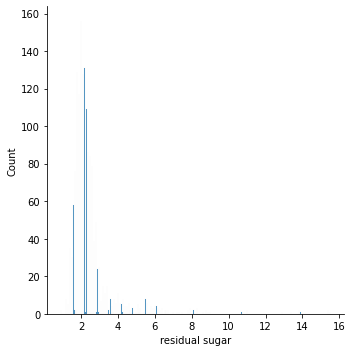

In [ ]:
sns.displot(x = "residual sugar", binwidth = 0.01, data = df)

In [ ]:
#Residual sugar is the amount of sugar left after fermentation. 
#It is rare to find wine with residual sugar content less than 1 g/l and wine with residual sugar content more than 45 g/l.
#Therefore, these data are considered as outliers and replaced by average values.
mean = df.loc[(df['residual sugar']>1) & (df['residual sugar'] <45), 'residual sugar'].mean()
df.loc[(df['residual sugar']<1) | (df['residual sugar']> 45), 'residual sugar'] = np.nan
df.fillna(mean,inplace=True) 

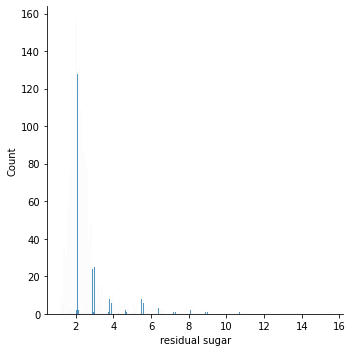

In [ ]:
sns.displot(x = "residual sugar", binwidth = 0.01, data = df)

## 1. Exploratory Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Frequency')

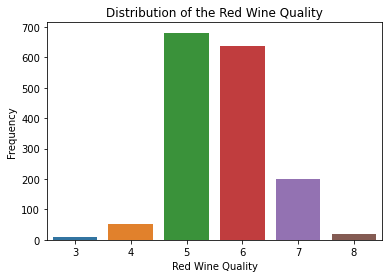

In [ ]:
quality_dist = sns.countplot(df['quality'])
quality_dist.set_title('Distribution of the Red Wine Quality')
quality_dist.set_xlabel('Red Wine Quality')
quality_dist.set_ylabel('Frequency')

In [ ]:
#check how the data columns are distributed in the dataset¶（only keeping meaningful distribution)

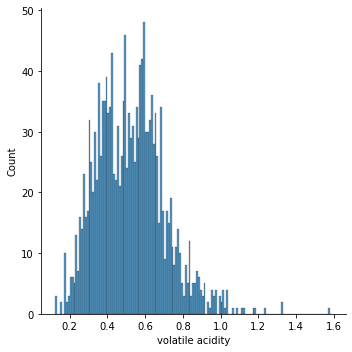

In [ ]:
#right skewed distribution, mainly cluster between 0.25 to 0.65g/dm3 
sns.displot(x = "volatile acidity", binwidth = 0.01, data = df)

<Figure size 720x432 with 0 Axes>

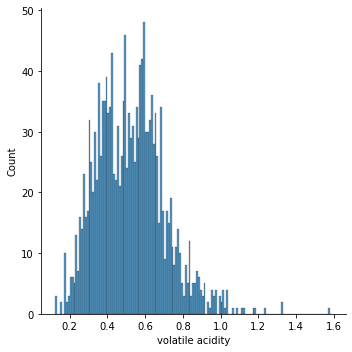

In [ ]:
# negative correlation: As quality goes higher, volatile acidity roughly follows a deceasing trend. 
fig1 = plt.figure(figsize = (10,6))
sns.displot(x = "volatile acidity", binwidth = 0.01, data = df)

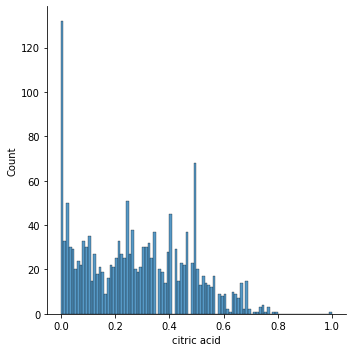

In [ ]:
sns.displot(x = "citric acid", binwidth = 0.01, data = df)

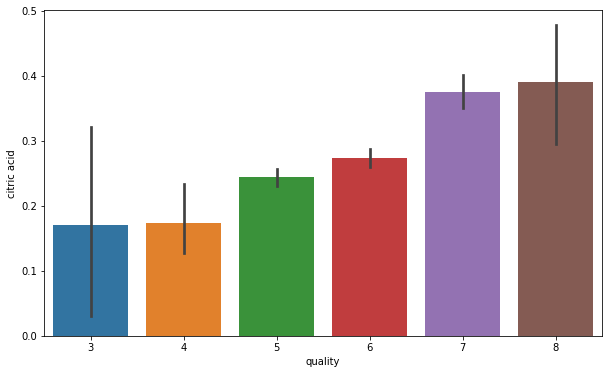

In [ ]:
#positive correlation: citric acid increases, leading to quality increasing. 
fig2 = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'citric acid', data = df)

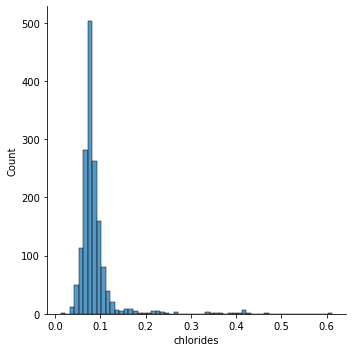

In [ ]:
#The distribution of chloride skewed to the right. Most of the data gether in the area less than 0.1.
sns.displot(x="chlorides",binwidth = 0.01, data = df)

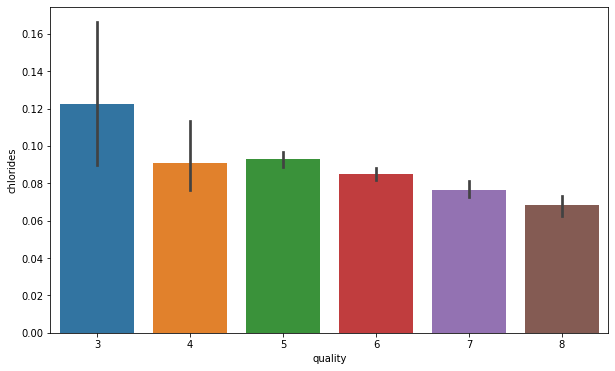

In [ ]:
#negative correlation 
fig4 = plt.figure(figsize =(10,6))
sns.barplot(x = 'quality', y='chlorides', data = df)

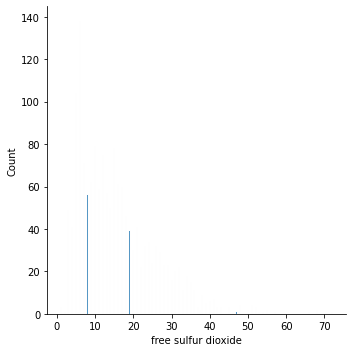

In [ ]:
# Binary; all less than 20 g/dm^3
sns.displot(x="free sulfur dioxide",binwidth = 0.01, data = df)

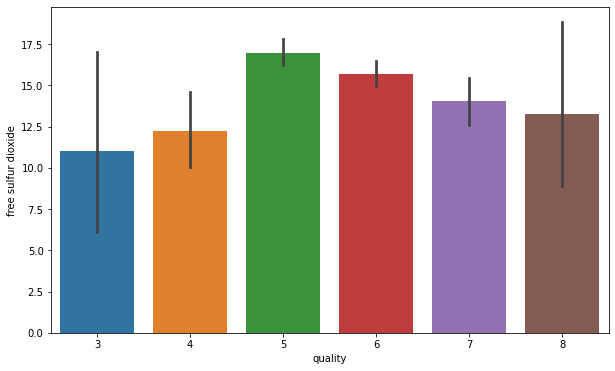

In [ ]:
fig5 = plt.figure(figsize =(10,6))
sns.barplot(x = 'quality', y='free sulfur dioxide', data = df)

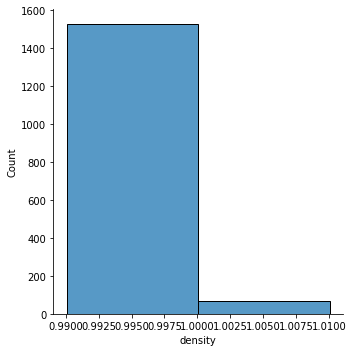

In [ ]:
sns.displot(x ="density",binwidth = 0.01, data = df )

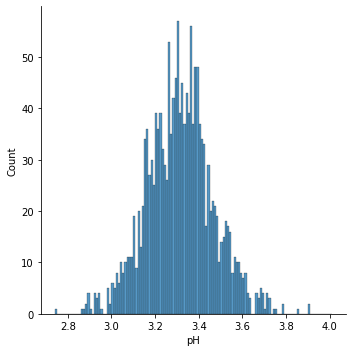

In [ ]:
# close to normal distribution 
sns.displot(x ="pH",binwidth = 0.01, data = df )

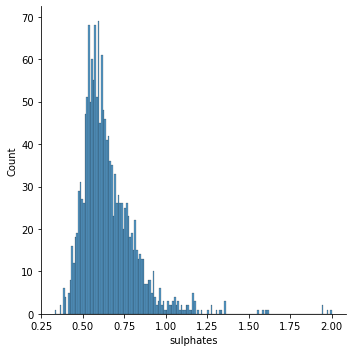

In [ ]:
#The distribution of sulphates skewed to the right. Median< mean. Most of the data gether in the area less than 1.
sns.displot(x="sulphates",binwidth = 0.01, data= df)

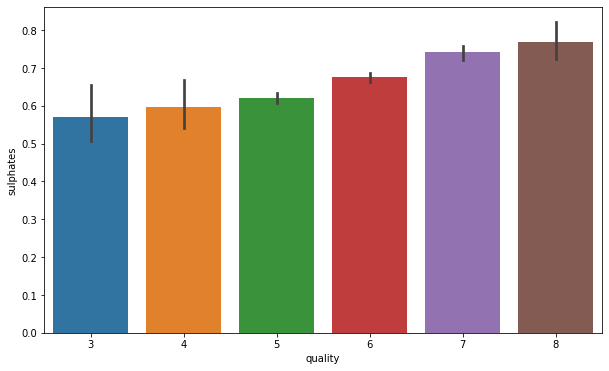

In [ ]:
# positive correlation
fig6 = plt.figure(figsize =(10,6))
sns.barplot(x = 'quality', y='sulphates', data = df)

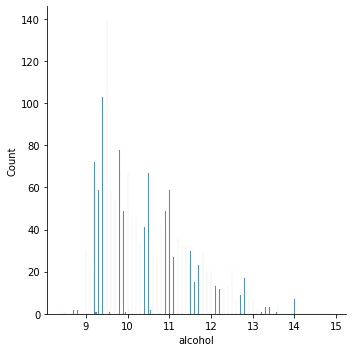

In [ ]:
sns.displot(x="alcohol",binwidth = 0.01, data= df)

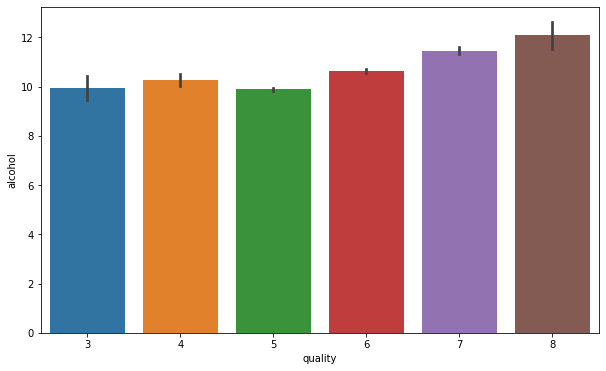

In [ ]:
fig7 = plt.figure(figsize =(10,6))
sns.barplot(x = 'quality', y='alcohol', data = df)

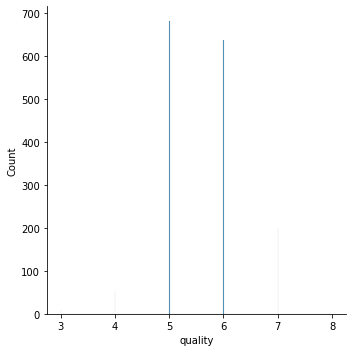

In [ ]:
#Most of the wines tested are of medium quality
sns.displot(x="quality",binwidth = 0.01, data= df)

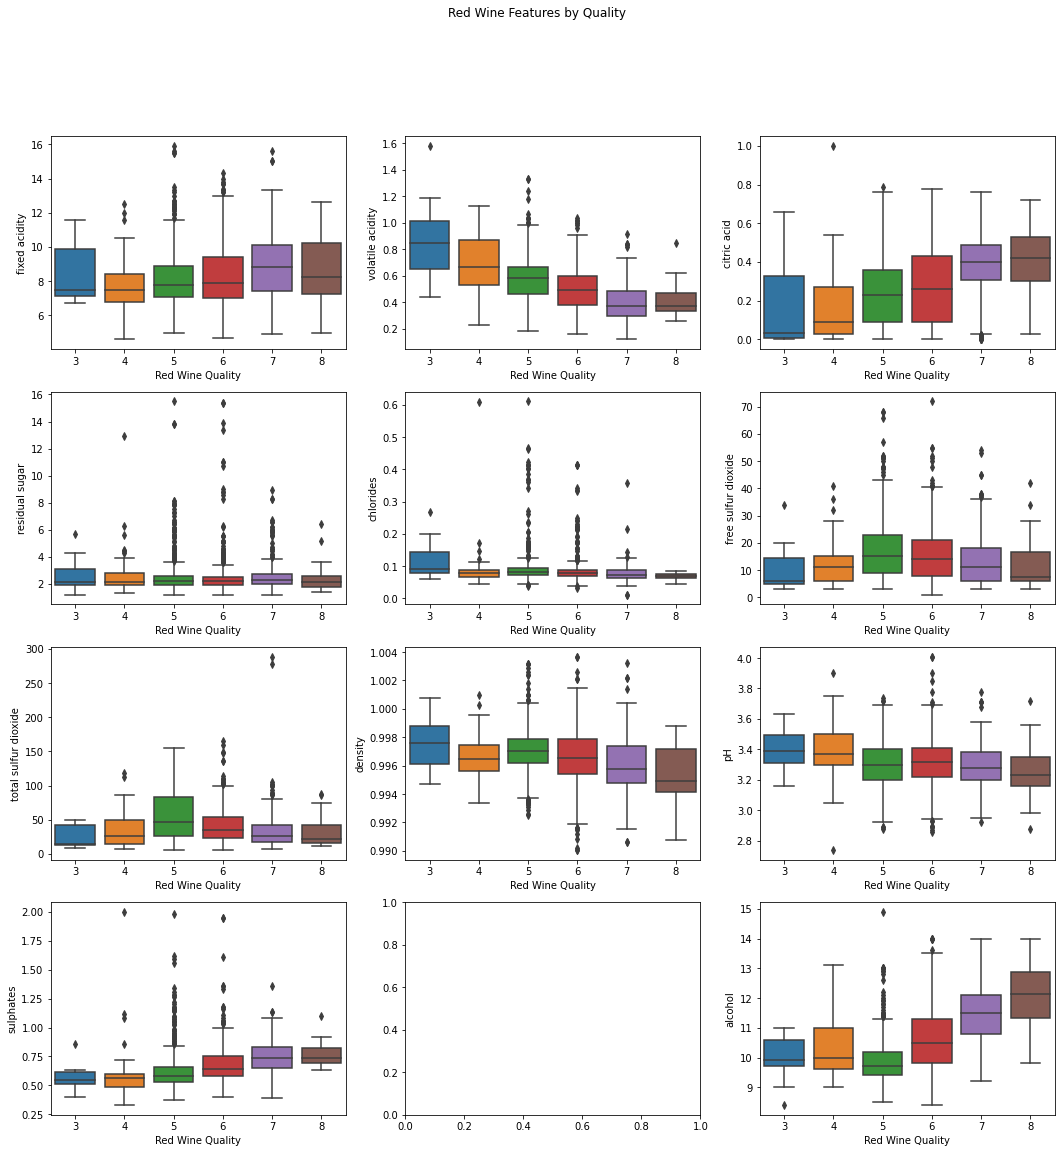

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(18, 18))

fig.suptitle('Red Wine Features by Quality')
a = sns.boxplot(ax=axes[0, 0], y = df['fixed acidity'], x = df['quality'].astype('category'))
b = sns.boxplot(ax=axes[0, 1], y = df['volatile acidity'], x = df['quality'].astype('category'))
c = sns.boxplot(ax=axes[0, 2], y = df['citric acid'], x = df['quality'].astype('category'))
d = sns.boxplot(ax=axes[1, 0], y = df['residual sugar'], x = df['quality'].astype('category'))
e = sns.boxplot(ax=axes[1, 1], y = df['chlorides'], x = df['quality'].astype('category'))
f = sns.boxplot(ax=axes[1, 2], y = df['free sulfur dioxide'], x = df['quality'].astype('category'))
g = sns.boxplot(ax=axes[2, 0], y = df['total sulfur dioxide'], x = df['quality'].astype('category'))
h = sns.boxplot(ax=axes[2, 1], y = df['density'], x = df['quality'].astype('category'))
i = sns.boxplot(ax=axes[2, 2], y = df['pH'], x = df['quality'].astype('category'))
j = sns.boxplot(ax=axes[3, 0], y = df['sulphates'], x = df['quality'].astype('category'))
k = sns.boxplot(ax=axes[3, 2], y = df['alcohol'], x = df['quality'].astype('category'))

for graph in [a,b,c,d,e,f,g,h,i,j,k]:
  graph.set_xlabel('Red Wine Quality')


There is a relative strong positive correlation between alcohol and quality. When the quality is between 3 to 5, the average content of alcohol decreases, and then the quality increases with the increase of alcohol. I doubt that other ingredients besides alcohol affect the quality of the wine in this range. The better quality wine is mostly distributed in the higher alcohol section.

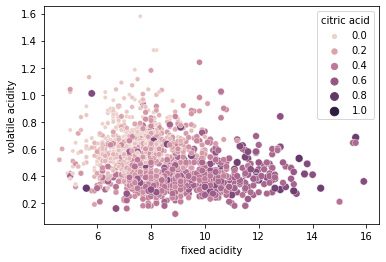

In [ ]:
acid_corr = sns.scatterplot(x = df['fixed acidity'], y = df['volatile acidity'], hue = df['citric acid'], size = df['citric acid'])

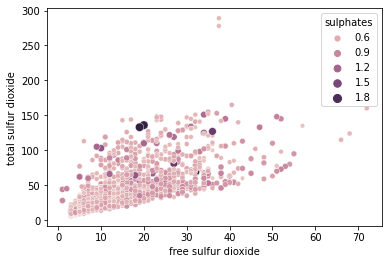

In [ ]:
sulfur_corr = sns.scatterplot(x = df['free sulfur dioxide'], y = df['total sulfur dioxide'], hue = df['sulphates'], size = df['sulphates'])

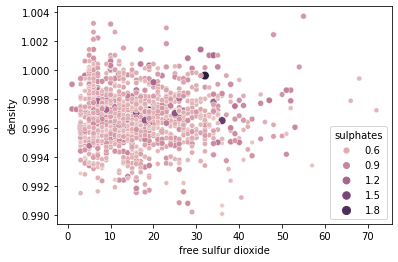

In [ ]:
sulfur_corr1 = sns.scatterplot(x = df['free sulfur dioxide'], y = df['density'], hue = df['sulphates'], size = df['sulphates'])

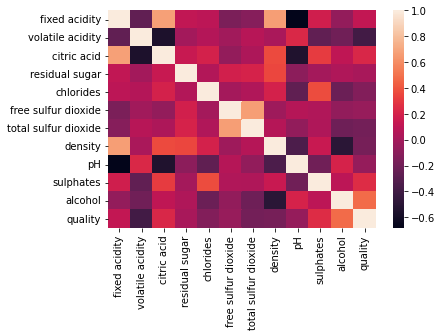

In [ ]:
hmap = sns.heatmap(df.corr())

volatile acidity & citric acid 

density & fixed acidity & pH & citric acid 


## 2. KMeans 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
df_kmeans = df.copy()
df_kmeans['quality'] = le.fit_transform(df_kmeans['quality'])

In [ ]:
X = df_kmeans.drop('quality',axis=1).values
y = df_kmeans['quality'].values.reshape(-1,1)

Method: 1 - Elbow method
Elbow method makes of use Sum of Squared Error or Within-cluster sum of square (WSS)

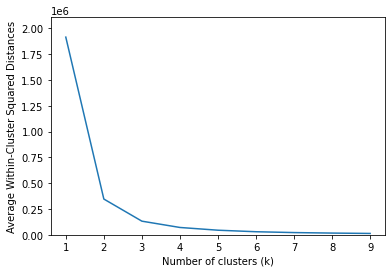

In [ ]:
import matplotlib.pylab as plt
inertia = []  # The SSE value
for n_clusters in range(1,10):
    kmeans = KMeans(n_clusters=n_clusters,random_state=42).fit(df_kmeans)
    inertia.append(kmeans.inertia_/n_clusters)
 #finding the average    
inertias =pd.DataFrame({'n_clusters':range(1,10),'inertia':inertia})

ax = inertias.plot(x='n_clusters',y='inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0,1.1*inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

Method 2 : silhouette_score


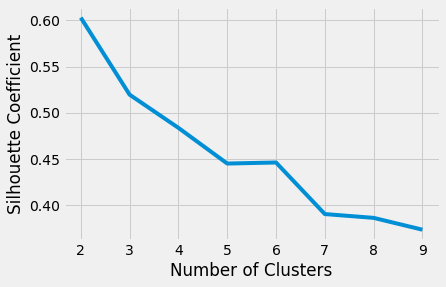

In [ ]:
from sklearn.metrics import silhouette_score
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(df_kmeans)
    score = silhouette_score(df_kmeans, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
y_kmeans = kmeans.fit_predict(X)

In [ ]:
# plt.scatter(df[y_kmeans == 0, 0], df[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
# plt.scatter(df[y_kmeans == 1, 0], df[y_kmeans== 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')

standardization 

In [ ]:
from scipy.stats import zscore

In [ ]:
df_scaled=df.apply(zscore)
df_scaled.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528360          0.961877    -1.391472       -0.455060  -0.243707   
1      -0.298547          1.967442    -1.391472        0.041996   0.223875   
2      -0.298547          1.297065    -1.186070       -0.171028   0.096353   
3       1.654856         -1.384443     1.484154       -0.455060  -0.264960   
4      -0.528360          0.961877    -1.391472       -0.455060  -0.243707   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466193             -0.379133  0.558274  1.288643  -0.579207   
1             0.872638              0.624363  0.028261 -0.719933   0.128950   
2            -0.083669              0.229047  0.134264 -0.331177  -0.048089   
3             0.107592              0.411500  0.664277 -0.979104  -0.461180   
4            -0.466193             -0.379133  0.558274  1.288643  -0.579207   

    alcohol   quality  
0 -0.960246 -0.787823  
1 -0.584777 -0.787823  
2 -0.584777 -0.787823  
3 -0.584777  0.450848  
4 -0.960246 -0.787823

In [ ]:
model1=KMeans(n_clusters=2)

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 42)
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 42)

In [ ]:
cluster_range=range(1,15)
cluster_error=[]
for a in cluster_range:
    cluster=KMeans(a,n_init=10)
    cluster.fit(df_scaled)
    cluster_error.append(cluster.inertia_)
cluster_df=pd.DataFrame({'num_cluster':cluster_range,'cluster_error':cluster_error})
cluster_df

num_cluster  cluster_error
0             1   19188.000000
1             2   15778.802053
2             3   14033.679116
3             4   12667.396659
4             5   11357.877028
5             6   10566.363151
6             7    9815.812637
7             8    9438.027618
8             9    9078.992417
9            10    8801.694900
10           11    8563.726827
11           12    8337.561999
12           13    8090.240221
13           14    7912.406925

In [ ]:
#we import the kmeans algorithm from sklearn
kmeans= KMeans(n_clusters=2)

In [ ]:
#we use the ".fit" command to use the kmeans algorithm on our data
kmeans.fit(df_scaled)

KMeans(n_clusters=2)

In [ ]:
#We create a new columnthat records for each wine the category it was given
df_kmeans['category']= kmeans.fit_predict(df)


In [ ]:
#prints out the different categories we have and the number of wines that were assigned to it
df_kmeans['category'].value_counts()

0    1179
1     420
Name: category, dtype: int64

separated into 2 distinct groups

Category 0: has 1179 wines.

Category 1: has 420 wines.

In [ ]:
centroids=kmeans.cluster_centers_
# pd.DataFrame(centroids,columns=df.columns)
centroids

array([[8.42425785e+00, 5.19334182e-01, 2.66539440e-01, 2.39427481e+00,
        8.54461408e-02, 1.23719254e+01, 3.03443596e+01, 9.96676836e-01,
        3.31552163e+00, 6.56530958e-01, 1.05402177e+01, 5.72434266e+00],
       [8.02595238e+00, 5.51642857e-01, 2.83428571e-01, 2.95233742e+00,
        9.31380952e-02, 2.57083333e+01, 9.17285714e+01, 9.96942738e-01,
        3.29873810e+00, 6.62690476e-01, 1.00938889e+01, 5.38809524e+00]])

HIERARCHICAL CLUSTERING ALGORITHM

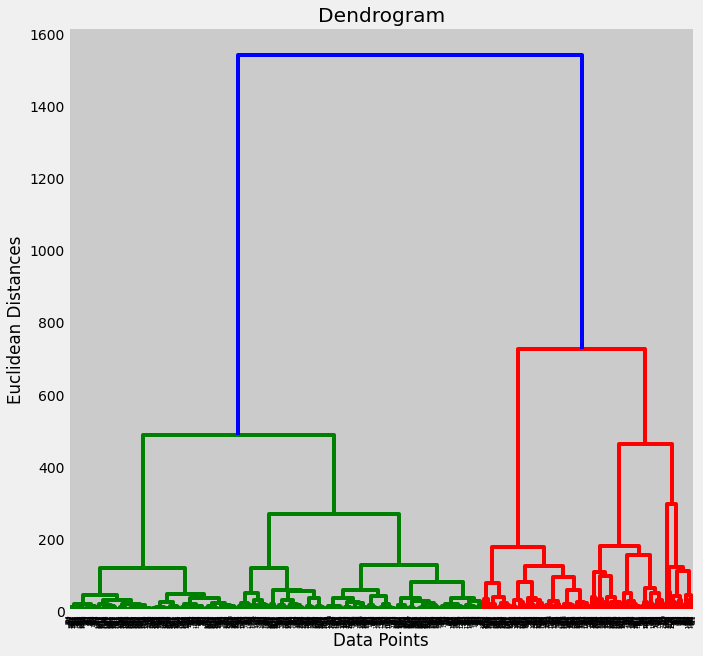

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
plt.figure(figsize=[10,10])
merg = linkage(df_kmeans, method='ward')
dendrogram(merg, leaf_rotation=90)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distances')
plt.show()

From the dendrogram we can read there are 2 classes in our data set.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

hie_clus = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster2 = hie_clus.fit_predict(df_scaled)

df_h = df_scaled.copy(deep=True)
df_h['category'] = cluster2

In [ ]:
df_h['category']=df_h['category'].astype('object')

In [ ]:
print('Original Data Classes:')
print(df['quality'].value_counts())
print('-' * 30)
print('K-Means Predicted Data Classes:')
print(df_kmeans['category'].value_counts())
print('-' * 30)
print('Hierarchical Predicted Data Classes:')
print(df_h['category'].value_counts())

Original Data Classes:
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
------------------------------
K-Means Predicted Data Classes:
0    1179
1     420
Name: category, dtype: int64
------------------------------
Hierarchical Predicted Data Classes:
0    1334
1     265
Name: category, dtype: int64


## Decision Tree

In [ ]:
# Train test split
# full model with all features
# partial model with only the features that are shown to be correlated with the red wine quality
X_full = df.copy()
X_full = X_full.drop('quality', axis = 1)
X_part = df[['volatile acidity','citric acid','chlorides','free sulfur dioxide','sulphates','alcohol']].copy()
y = df['quality']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full,y,test_size = 0.30, random_state=42)
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_part,y,test_size = 0.30, random_state=42)

In [ ]:
# Create decision tree instances and fit them into full and partial dataset
clf_full = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
clf_part = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')

clf_full = clf_full.fit(X_train_full, y_train_full)
clf_part = clf_part.fit(X_train_part, y_train_full)

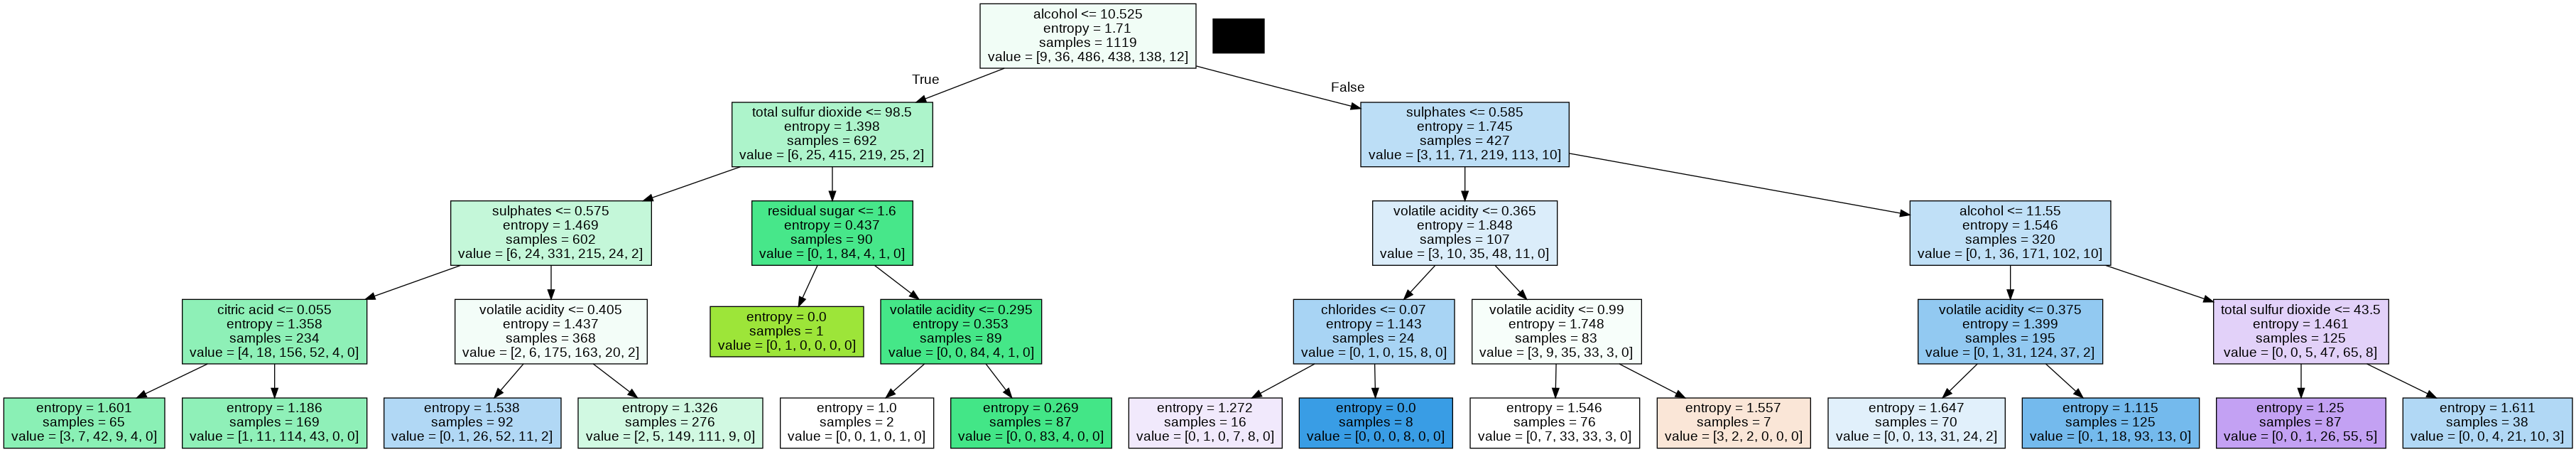

In [ ]:
# Visualize the full model
import pydotplus 
from IPython.display import Image
dot_data = tree.export_graphviz(clf_full, feature_names=X_train_full.columns
                ,filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

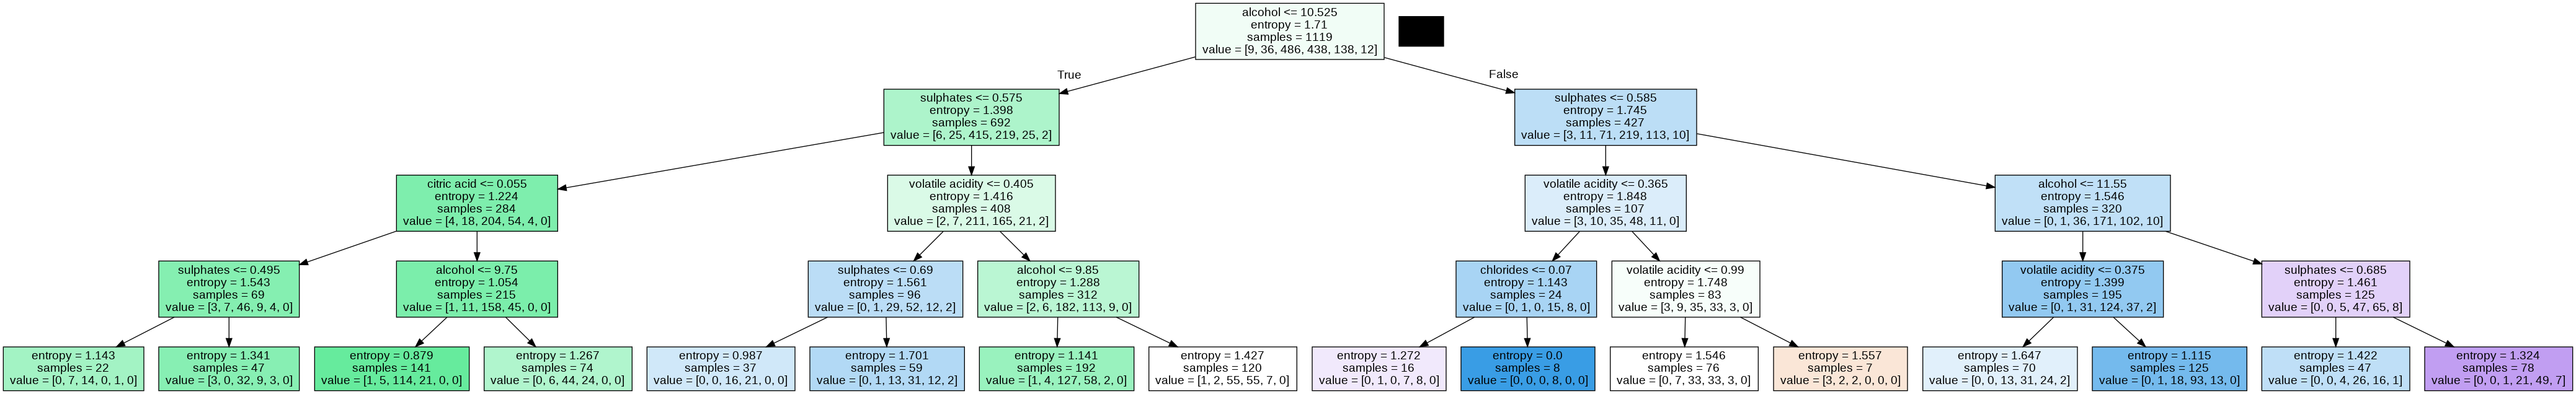

In [ ]:
# Visualize the partial model
import pydotplus 
from IPython.display import Image
dot_data = tree.export_graphviz(clf_part, feature_names=X_train_part.columns
                ,filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [ ]:
# Test the full model
from sklearn.metrics import classification_report, confusion_matrix
y_pred_tree_full = clf_full.predict(X_test_full)

print(confusion_matrix(y_test_full, y_pred_tree_full))
print(classification_report(y_test_full, y_pred_tree_full))

[[  0   0   1   0   0   0]
 [  1   0  12   4   0   0]
 [  0   1 162  29   3   0]
 [  0   0 104  70  26   0]
 [  0   0  10  34  17   0]
 [  0   0   0   4   2   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        17
           5       0.56      0.83      0.67       195
           6       0.50      0.35      0.41       200
           7       0.35      0.28      0.31        61
           8       0.00      0.00      0.00         6

    accuracy                           0.52       480
   macro avg       0.24      0.24      0.23       480
weighted avg       0.48      0.52      0.48       480



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test the partial model
y_pred_tree_part = clf_part.predict(X_test_part)

print(confusion_matrix(y_test_part, y_pred_tree_part))
print(classification_report(y_test_part, y_pred_tree_part))

[[  0   0   1   0   0   0]
 [  1   0  12   4   0   0]
 [  0   0 161  31   3   0]
 [  0   0 104  74  22   0]
 [  0   0  10  33  18   0]
 [  0   0   0   2   4   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        17
           5       0.56      0.83      0.67       195
           6       0.51      0.37      0.43       200
           7       0.38      0.30      0.33        61
           8       0.00      0.00      0.00         6

    accuracy                           0.53       480
   macro avg       0.24      0.25      0.24       480
weighted avg       0.49      0.53      0.49       480



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the classfication report, the partial model provides a higher accuracy and higher f1 score in predicting medium quality red wine with fewer predictors. Note that the inital set-up of the model has the max depth = 4. 

In [ ]:
# Create a function to find the best max_depth based on the designated error
from logging import error
from sklearn import metrics
def findBestDepth(x_train, x_test, y_train, y_test, method):
  error = []
  for i in range(1,11):
    clf = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=i, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if method == 'MAE':
      error.append(metrics.mean_absolute_error(y_test, y_pred))
    if method == 'MSE':
      error.append(metrics.mean_squared_error(y_test, y_pred))
    if method == 'RMSE':
      error.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  bestDepth = error.index(min(error)) + 1
  fig = sns.lineplot(x = range(1,11), y = error)
  fig.set_xlabel('Max_depth')
  fig.set_ylabel('Error')
  return bestDepth

5

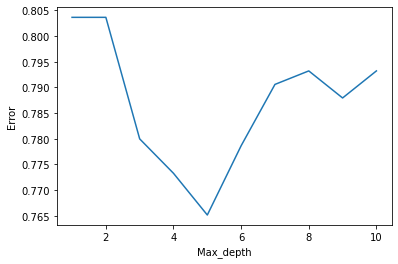

In [ ]:
findBestDepth(X_train_part, X_test_part, y_train_part, y_test_part, 'RMSE')

Max depth = 5 is the global minimum no matter which error we use (MAE, MSE, RMSE).  

5

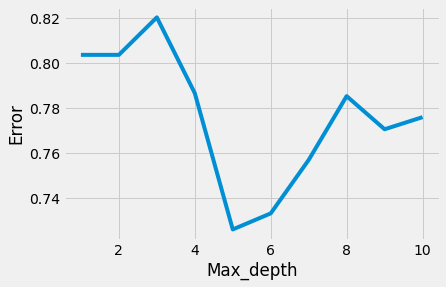

In [ ]:
findBestDepth(X_train_full, X_test_full, y_train_full, y_test_full, 'RMSE')

Max depth = 5 is the global minimum no matter which error we use (MAE, MSE, RMSE).  

In [ ]:
clf_part = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
clf_part = clf_part.fit(X_train_part, y_train_part)
y_pred_tree_part = clf_part.predict(X_test_part)

print(confusion_matrix(y_test_part, y_pred_tree_part))
print(classification_report(y_test_part, y_pred_tree_part))

cv = KFold(n_splits=3, random_state=42, shuffle=True)
print(np.mean(cross_val_score(clf_part, X_part, y, cv=cv)))

[[  0   0   1   0   0   0]
 [  0   1  11   5   0   0]
 [  0   0 145  48   2   0]
 [  0   0  82 102  16   0]
 [  0   0   8  37  16   0]
 [  0   0   1   3   2   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       1.00      0.06      0.11        17
           5       0.58      0.74      0.65       195
           6       0.52      0.51      0.52       200
           7       0.44      0.26      0.33        61
           8       0.00      0.00      0.00         6

    accuracy                           0.55       480
   macro avg       0.43      0.26      0.27       480
weighted avg       0.55      0.55      0.53       480

0.5534709193245778


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf_full = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
clf_full = clf_full.fit(X_train_full, y_train_full)
y_pred_tree_full = clf_full.predict(X_test_full)

print(confusion_matrix(y_test_full, y_pred_tree_full))
print(classification_report(y_test_full, y_pred_tree_full))

print(np.mean(cross_val_score(clf_full, X_full, y, cv=cv)))

[[  0   0   1   0   0   0]
 [  0   1   8   8   0   0]
 [  0   1 150  41   3   0]
 [  0   0  78 105  17   0]
 [  0   0   2  37  22   0]
 [  0   0   0   3   3   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.50      0.06      0.11        17
           5       0.63      0.77      0.69       195
           6       0.54      0.53      0.53       200
           7       0.49      0.36      0.42        61
           8       0.00      0.00      0.00         6

    accuracy                           0.58       480
   macro avg       0.36      0.29      0.29       480
weighted avg       0.56      0.58      0.56       480

0.5697310819262039


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


By using the optimal max_depth in the full model, the classification report indicates that the full model with more predictor is better in accuracy.

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_part, y_pred_tree_part))
print('MSE:', metrics.mean_squared_error(y_test_part, y_pred_tree_part))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_part, y_pred_tree_part)))

MAE: 0.49375
MSE: 0.5854166666666667
RMSE: 0.7651252620758686


In [ ]:
# Final model error summary
print('MAE:', metrics.mean_absolute_error(y_test_full, y_pred_tree_full))
print('MSE:', metrics.mean_squared_error(y_test_full, y_pred_tree_full))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_full, y_pred_tree_full)))

MAE: 0.45625
MSE: 0.5270833333333333
RMSE: 0.7260050504874834


Based on the classification report and confusion matrix of the final model, we can see that it has higher recall and lower precision, implying that the model is more likely to have type I error. In other words, the error the model inclines to make is to predict the red wine quality but it is in fact wrong. However, beause our target variable has multiple cateogories, we need a more in-depth analysis.

It is noteworthy that the model is performing well in predicitng red wine with quality 5 and 6 and performing bad in predicitng red wine with quality 7. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Prediction when red wine quality equals 5')

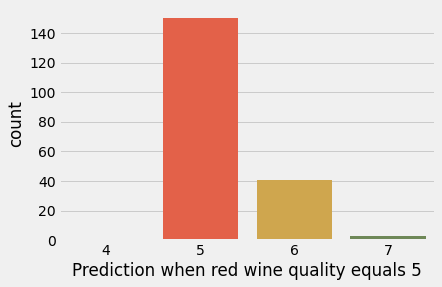

In [ ]:
from matplotlib import test
test_pred = pd.DataFrame(y_test_full)
test_pred['pred'] = y_pred_tree_full
fig1 = sns.countplot(test_pred[test_pred['quality'] == 5]['pred'])
fig1.set_xlabel('Prediction when red wine quality equals 5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Prediction when red wine quality equals 6')

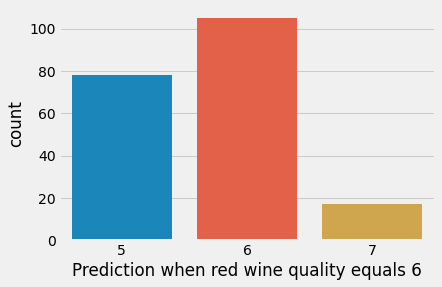

In [ ]:
fig2 = sns.countplot(test_pred[test_pred['quality'] == 6]['pred'])
fig2.set_xlabel('Prediction when red wine quality equals 6')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Prediction when red wine quality equals 7')

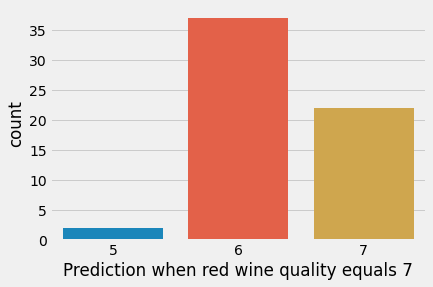

In [ ]:
fig3 = sns.countplot(test_pred[test_pred['quality'] == 7]['pred'])
fig3.set_xlabel('Prediction when red wine quality equals 7')

When the model incorrectly predicts the quality to be 5, it is more likely to classify it to be 6 (over-predict). 

When the model incorrectly predicts the quality to be 6, it is more likely to classify it to be 5 (under-predict). 

When the model incorrectly predicts the quality to be 7, it is more likely to classify it to be 6 (under predict). 


Feature: 0, Score: 0.19093
Feature: 1, Score: 0.03390
Feature: 2, Score: 0.05418
Feature: 3, Score: 0.07721
Feature: 4, Score: 0.23430
Feature: 5, Score: 0.40948


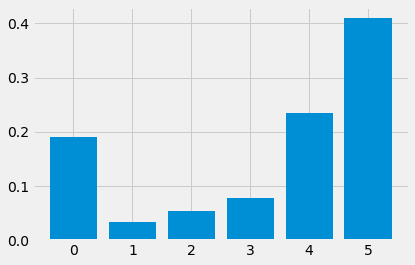

Index(['volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide',
       'sulphates', 'alcohol'],
      dtype='object')


In [ ]:
# Important features
importance = clf_part.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(X_part.columns)

Feature: 0, Score: 0.02449
Feature: 1, Score: 0.15802
Feature: 2, Score: 0.02073
Feature: 3, Score: 0.01244
Feature: 4, Score: 0.02195
Feature: 5, Score: 0.01819
Feature: 6, Score: 0.11358
Feature: 7, Score: 0.03353
Feature: 8, Score: 0.01833
Feature: 9, Score: 0.20087
Feature: 10, Score: 0.37788


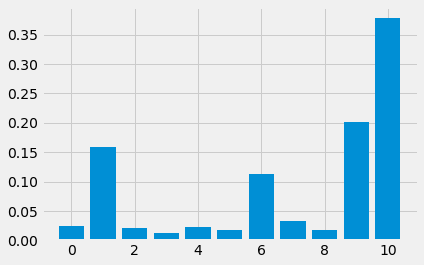

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [ ]:
# Important features
importance = clf_full.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(X_full.columns)

Based on the final model, the three most important variables are volatile acidity, sulphates, and alcohol. Based on the full model, the top three are the same. These two graphs imply that these three features are valuable in predicting/evaluating the red wine quality.

6

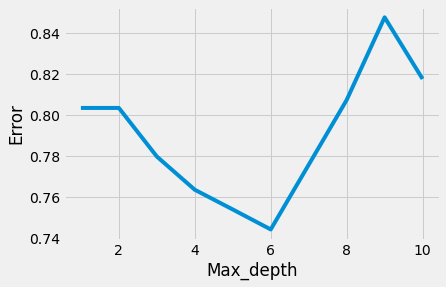

In [ ]:
# Model after variable selection (top 3)
X_lit = df[['volatile acidity', 'sulphates', 'alcohol']]
X_train_lit, X_test_lit, y_train_lit, y_test_lit = train_test_split(X_lit,y,test_size = 0.30, random_state=42)
m_depth = findBestDepth(X_train_lit, X_test_lit, y_train_lit, y_test_lit, 'RMSE')
m_depth

In [ ]:
clf_lit = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
clf_lit = clf_lit.fit(X_train_lit, y_train_lit)
y_pred_tree_lit = clf_lit.predict(X_test_lit)

print(confusion_matrix(y_test_lit, y_pred_tree_lit))

[[  0   0   1   0   0   0]
 [  1   2  10   4   0   0]
 [  0   2 143  46   4   0]
 [  0   0  79 100  20   1]
 [  0   0   5  36  20   0]
 [  0   0   0   2   4   0]]


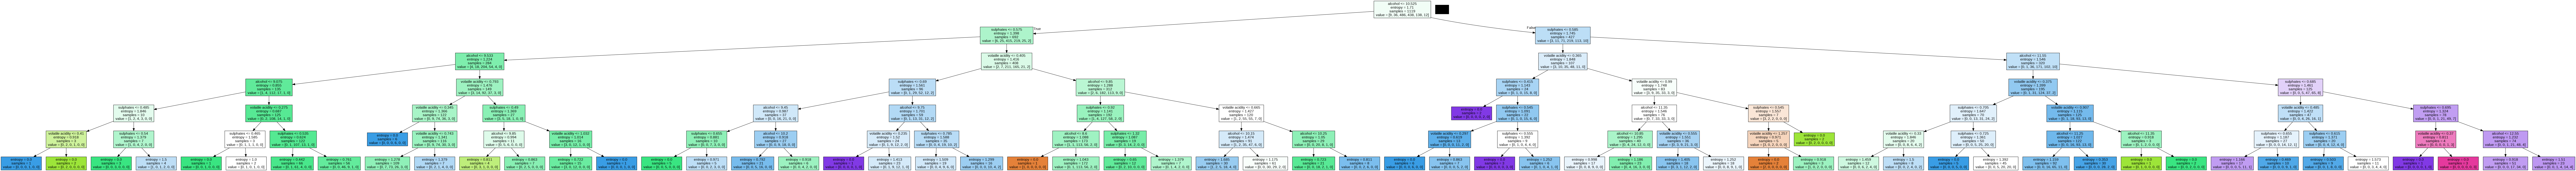

In [ ]:
# Visualize the shrinked model
import pydotplus 
from IPython.display import Image
dot_data = tree.export_graphviz(clf_lit, feature_names=X_train_lit.columns
                ,filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

By shriking the model to only have three input features, the classification result is still similar to the partial model

In [ ]:
print(classification_report(y_test_lit, y_pred_tree_lit))
print(np.mean(cross_val_score(clf_lit, X_lit, y, cv=cv)))
print('MAE:', metrics.mean_absolute_error(y_test_lit, y_pred_tree_lit))
print('MSE:', metrics.mean_squared_error(y_test_lit, y_pred_tree_lit))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_lit, y_pred_tree_lit)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.50      0.12      0.19        17
           5       0.60      0.73      0.66       195
           6       0.53      0.50      0.52       200
           7       0.42      0.33      0.37        61
           8       0.00      0.00      0.00         6

    accuracy                           0.55       480
   macro avg       0.34      0.28      0.29       480
weighted avg       0.54      0.55      0.54       480

0.5753595997498437
MAE: 0.48333333333333334
MSE: 0.5541666666666667
RMSE: 0.7444237144709098


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        17
           5       0.62      0.76      0.68       195
           6       0.55      0.57      0.56       200
           7       0.38      0.20      0.26        61
           8       0.00      0.00      0.00         6

    accuracy                           0.57       480
   macro avg       0.26      0.26      0.25       480
weighted avg       0.53      0.57      0.54       480

0.5691056910569107
MAE: 0.475
MSE: 0.575
RMSE: 0.758287544405155


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


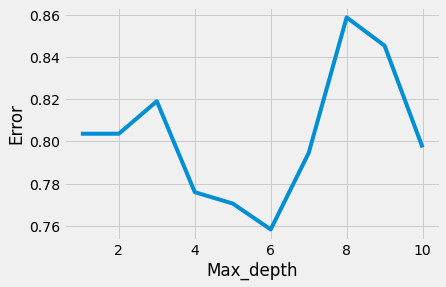

In [ ]:
# Model after variable selection (top 5)
X_lit = df[['volatile acidity', 'sulphates', 'alcohol', 'total sulfur dioxide', 'density']]
X_train_lit, X_test_lit, y_train_lit, y_test_lit = train_test_split(X_lit,y,test_size = 0.30, random_state=42)
m_depth = findBestDepth(X_train_lit, X_test_lit, y_train_lit, y_test_lit, 'RMSE')
clf_lit = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
clf_lit = clf_lit.fit(X_train_lit, y_train_lit)
y_pred_tree_lit = clf_lit.predict(X_test_lit)

print(classification_report(y_test_lit, y_pred_tree_lit))
print(np.mean(cross_val_score(clf_lit, X_lit, y, cv=cv)))
print('MAE:', metrics.mean_absolute_error(y_test_lit, y_pred_tree_lit))
print('MSE:', metrics.mean_squared_error(y_test_lit, y_pred_tree_lit))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_lit, y_pred_tree_lit)))

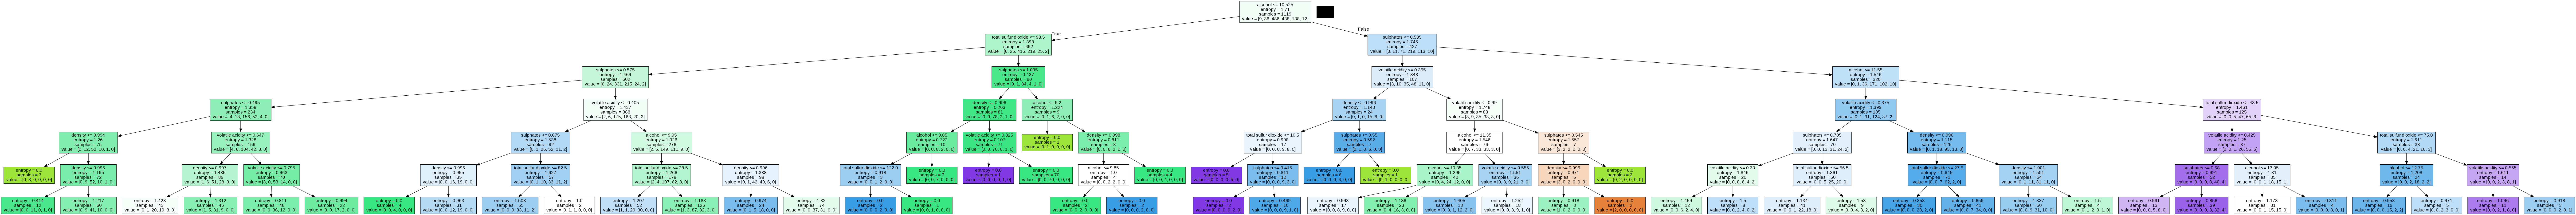

In [ ]:
# Visualize the shrinked model
dot_data = tree.export_graphviz(clf_lit, feature_names=X_train_lit.columns
                ,filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## 3. Linear Regression Model

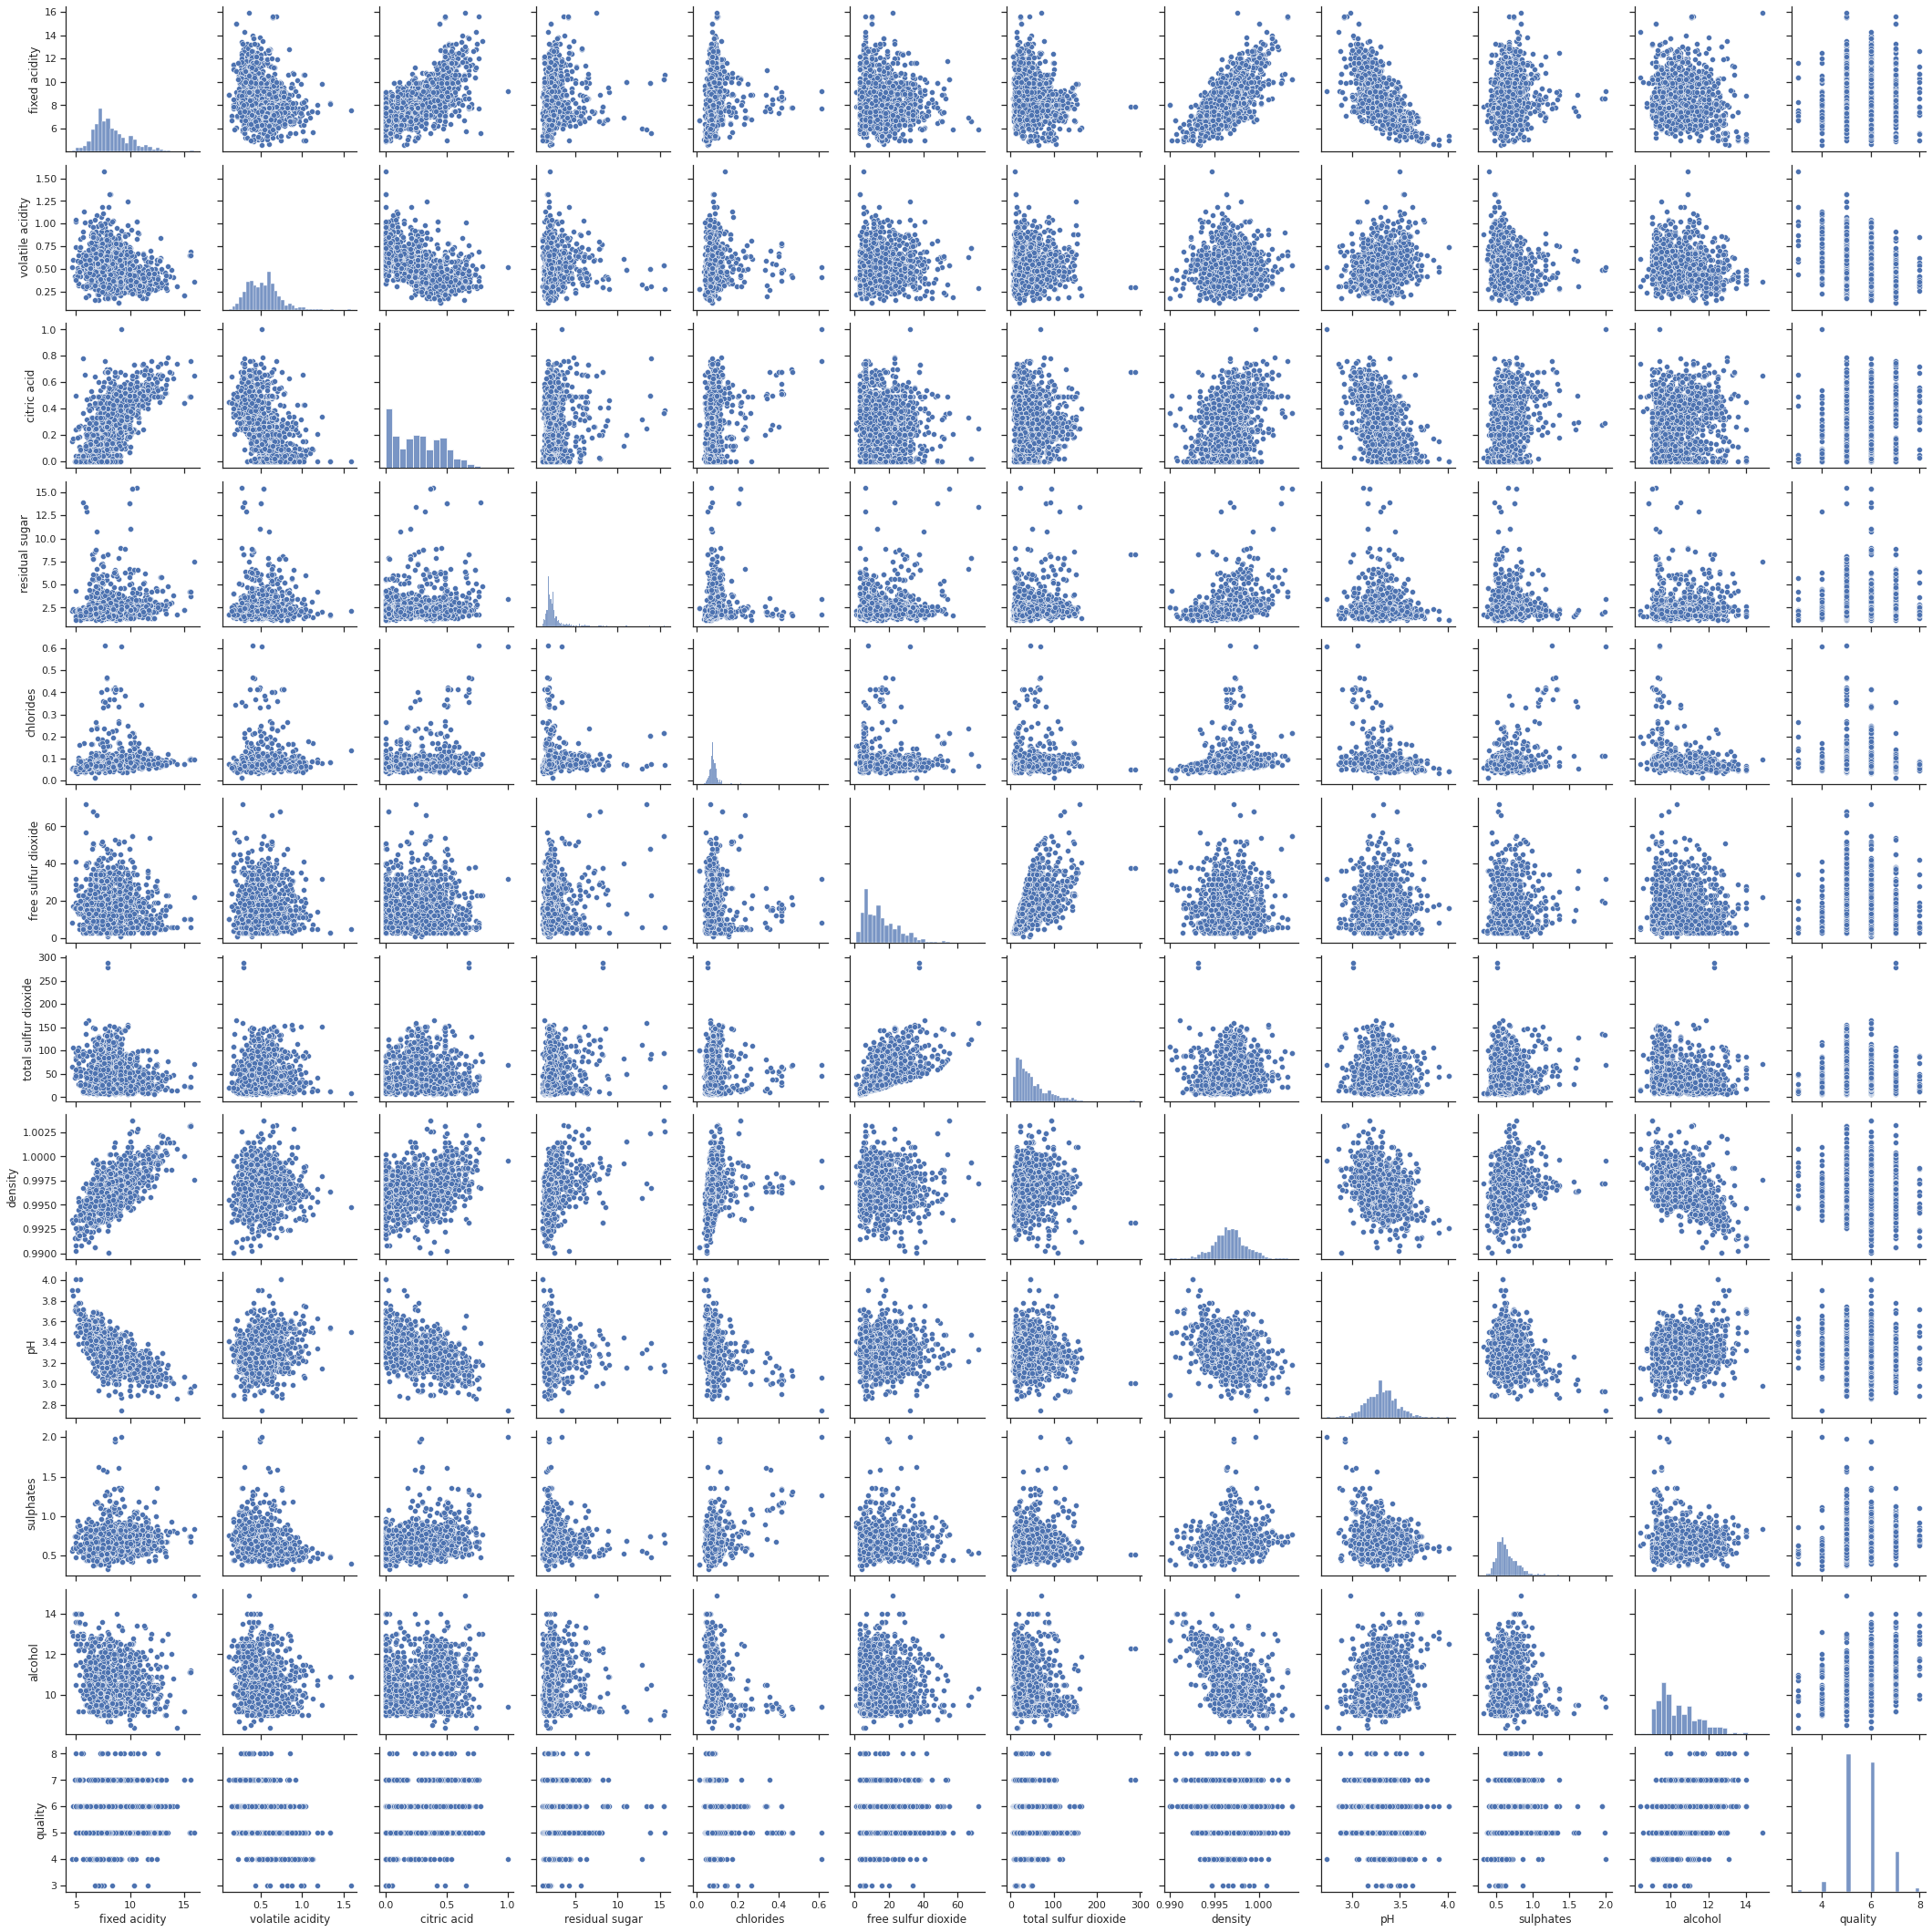

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df)

We can see some correlations in pairs:
  fixed acidity vs. density;
  fixed acidity vs. pH;
  fixed acidity vs. critric acid;
  free SO2 vs. total SO2;
  density vs. alcolhol;
  sulphates vs. pH.

In [ ]:
##corrleation between fixed acidty and density
fa_vs_d=np.corrcoef(df['fixed acidity'],df['density'])
print("The correlation coefficient between fixed acidity and density is ",fa_vs_d[0,1])

The correlation coefficient between fixed acidity and density is  0.6680472921189738


In [ ]:
fa_vs_ph=np.corrcoef(df['fixed acidity'],df['pH'])
print("The correlation coefficient between fixed acidity and pH is ",fa_vs_ph[0,1])

The correlation coefficient between fixed acidity and pH is  -0.6829781945685316


In [ ]:
fa_vs_ac=np.corrcoef(df['fixed acidity'],df['citric acid'])
print("The correlation coefficient between fixed acidity and citric is ",fa_vs_ac[0,1])

The correlation coefficient between fixed acidity and citric is  0.671703434764106


In [ ]:
fs_vs_ts=np.corrcoef(df['free sulfur dioxide'],df['total sulfur dioxide'])
print("The correlation coefficient between free sulfur dioxide and total sulfur dioxide is ",fs_vs_ts[0,1])

The correlation coefficient between free sulfur dioxide and total sulfur dioxide is  0.6676664504810218


In [ ]:
d_vs_a=np.corrcoef(df['density'],df['alcohol'])
print("The correlation coefficient between density and alcohol is ",d_vs_a[0,1])

The correlation coefficient between density and alcohol is  -0.4961797702417018


In [ ]:
s_vs_ph=np.corrcoef(df['sulphates'],df['pH'])
print("The correlation coefficient between sulphates and pH is ",s_vs_ph[0,1])

The correlation coefficient between sulphates and pH is  -0.19664760230437017


In [ ]:
##We've notice there are some pairs of vairables have rather high correlation coeffiencts, so we want to run VIF to detect multicolinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]


In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [ ]:
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                 feature          VIF
0          fixed acidity    74.431328
1       volatile acidity    17.054709
2            citric acid     9.181534
3         residual sugar     4.686154
4              chlorides     6.554866
5    free sulfur dioxide     6.444614
6   total sulfur dioxide     6.521867
7                density  1479.225805
8                     pH  1071.040076
9              sulphates    21.600972
10               alcohol   124.523929


VIF analysis confirms what we observe from the scatter plots matrix. Fixed acidity, volatile acidity, density, pH, sulphates, and alcohol all have VIF score above, which implies high multicollinearity. 


In [ ]:
##Next, we want to run PCA to determine which variables shall we include in our model. 
from sklearn.decomposition import PCA
pca=PCA()
pcs=pca.fit(df)
df_pca=pca.transform(df)
print("Original shape: {}".format(str(df.shape))) 
print("Reduced shape: {}".format(str(df_pca.shape)))

Original shape: (1599, 12)
Reduced shape: (1599, 12)


In [ ]:
pcs.explained_variance_ratio_

array([9.46084122e-01, 4.83487136e-02, 2.59578899e-03, 1.52045104e-03,
       1.04685488e-03, 3.34899194e-04, 3.10101658e-05, 1.93406638e-05,
       9.43409087e-06, 8.18588660e-06, 1.19902909e-06, 4.69988774e-10])

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm

In [ ]:
predictors=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
response='quality'


In [ ]:
X=df[predictors]
y=df[response]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.4, random_state=42)

In [ ]:
wine_quality_lm = LinearRegression()
wine_quality_lm.fit(x_train, y_train)
print (pd.DataFrame({'Predictor': X.columns, 'coefficient': wine_quality_lm.coef_}))

               Predictor  coefficient
0          fixed acidity     0.022978
1       volatile acidity    -1.223978
2            citric acid    -0.337949
3         residual sugar     0.021796
4              chlorides    -1.723439
5    free sulfur dioxide     0.002881
6   total sulfur dioxide    -0.003098
7                density   -26.090129
8                     pH    -0.329345
9              sulphates     0.712020
10               alcohol     0.282748


In [ ]:
y_lm_pred=wine_quality_lm.predict(x_test)

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_lm_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_lm_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_lm_pred)))

MAE: 0.5196729915549667
MSE: 0.42967980063440026
RMSE: 0.6554996572343881


## 4. Neural Network Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
X = df.drop(columns = ['quality'])
Y = df['quality']
# get dummy varaibles
processed_Y = pd.get_dummies(Y)
# train test split
train_X, valid_X, train_y, valid_y = train_test_split(X, processed_Y, test_size=0.3, random_state=42)

In [ ]:
# fit neural network model, choose tanh as activation model and default adam solver. 2 hidden layers with 12 neurons and 10 neurons
clf = MLPClassifier(hidden_layer_sizes = (12,10),activation = 'tanh', solver='adam',
                    random_state = 42, max_iter = 10000)
clf.fit(train_X, train_y.values)

MLPClassifier(activation='tanh', hidden_layer_sizes=(12, 10), max_iter=10000,
              random_state=42)

##### Training Set Performance

In [ ]:
confusionmatrix_train = pd.DataFrame(confusion_matrix(train_y.values.argmax(axis = 1),
                                                clf.predict(train_X).argmax(axis = 1)),
                               index = ['true rating = ' + str(i+3) for i in range(6)],
                               columns = ['predicted rating = ' + str(i+3) for i in range(6)])
confusionmatrix_train

predicted rating = 3  predicted rating = 4  \
true rating = 3                     3                     0   
true rating = 4                    14                     0   
true rating = 5                    54                     0   
true rating = 6                    56                     0   
true rating = 7                    19                     0   
true rating = 8                     2                     0   

                 predicted rating = 5  predicted rating = 6  \
true rating = 3                     6                     0   
true rating = 4                    19                     3   
true rating = 5                   352                    78   
true rating = 6                   122                   243   
true rating = 7                     6                    75   
true rating = 8                     0                     8   

                 predicted rating = 7  predicted rating = 8  
true rating = 3                     0                     0  
true rating = 4                     0                     0  
true rating = 5                     2                     0  
true rating = 6                    17                     0  
true rating = 7                    38                     0  
true rating = 8                     2                     0

In [ ]:
print('Model accuracy on training set is: ' + 
      str(accuracy_score(train_y.values.argmax(axis = 1), clf.predict(train_X).argmax(axis = 1))))

Model accuracy on training set is: 0.5683646112600537


##### Test Set Performance

In [ ]:
confusionmatrix_valid = pd.DataFrame(confusion_matrix(valid_y.values.argmax(axis = 1),
                                                clf.predict(valid_X).argmax(axis = 1)),
                               index = ['true rating = ' + str(i+3) for i in range(6)],
                               columns = ['predicted rating = ' + str(i+3) for i in range(6)])
confusionmatrix_valid

predicted rating = 3  predicted rating = 4  \
true rating = 3                     1                     0   
true rating = 4                     4                     0   
true rating = 5                    19                     0   
true rating = 6                    30                     0   
true rating = 7                     8                     0   
true rating = 8                     0                     0   

                 predicted rating = 5  predicted rating = 6  \
true rating = 3                     0                     0   
true rating = 4                    10                     3   
true rating = 5                   132                    43   
true rating = 6                    61                   102   
true rating = 7                     1                    48   
true rating = 8                     0                     4   

                 predicted rating = 7  predicted rating = 8  
true rating = 3                     0                     0  
true rating = 4                     0                     0  
true rating = 5                     1                     0  
true rating = 6                     7                     0  
true rating = 7                     4                     0  
true rating = 8                     2                     0

In [ ]:
print('Model accuracy on test set is: ' + 
      str(accuracy_score(valid_y.values.argmax(axis = 1), clf.predict(valid_X).argmax(axis = 1))))

Model accuracy on test set is: 0.4979166666666667


Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 3')

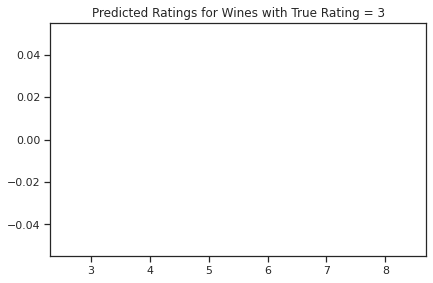

In [ ]:
plt.bar(x = [3,4,5,6,7,8], height = clf.predict(valid_X)[np.array(valid_y)[:,0] == 1].sum(0), 
        color = ['blue','red','red','red','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 3')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 4')

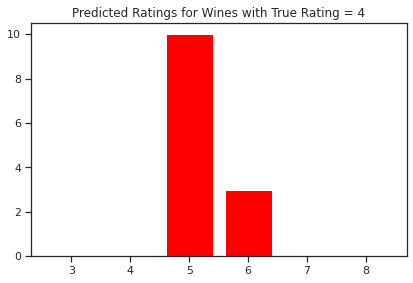

In [ ]:
plt.bar(x = [3,4,5,6,7,8], height = clf.predict(valid_X)[np.array(valid_y)[:,1] == 1].sum(0), 
        color = ['red','blue','red','red','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 4')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 5')

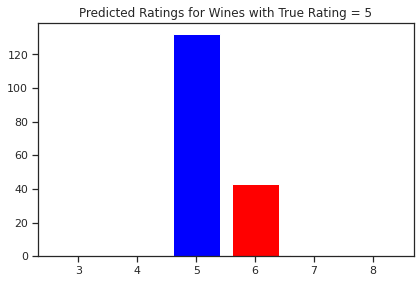

In [ ]:
plt.bar(x = [3,4,5,6,7,8], height = clf.predict(valid_X)[np.array(valid_y)[:,2] == 1].sum(0), 
        color = ['red','red','blue','red','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 5')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 6')

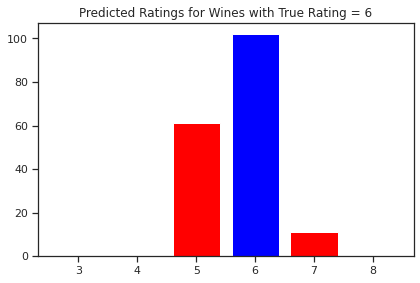

In [ ]:
plt.bar(x = [3,4,5,6,7,8], height = clf.predict(valid_X)[np.array(valid_y)[:,3] == 1].sum(0), 
        color = ['red','red','red','blue','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 6')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 7')

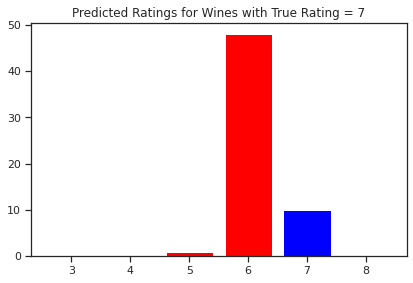

In [ ]:
plt.bar(x = [3,4,5,6,7,8], height = clf.predict(valid_X)[np.array(valid_y)[:,4] == 1].sum(0), 
        color = ['red','red','red','red','blue','red'])
plt.title('Predicted Ratings for Wines with True Rating = 7')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 8')

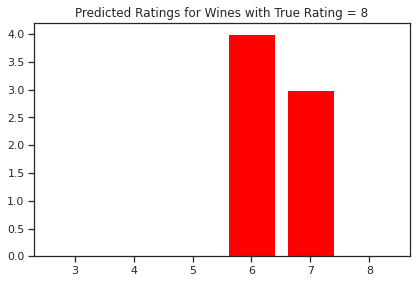

In [ ]:
plt.bar(x = [3,4,5,6,7,8], height = clf.predict(valid_X)[np.array(valid_y)[:,5] == 1].sum(0), 
        color = ['red','red','red','red','red','blue'])
plt.title('Predicted Ratings for Wines with True Rating = 8')

In [ ]:
print('MAE:', metrics.mean_absolute_error(valid_y.values.argmax(axis = 1), clf.predict(valid_X).argmax(axis = 1)))
print('MSE:', metrics.mean_squared_error(valid_y.values.argmax(axis = 1), clf.predict(valid_X).argmax(axis = 1)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(valid_y.values.argmax(axis = 1), clf.predict(valid_X).argmax(axis = 1))))

MAE: 0.7354166666666667
MSE: 1.4270833333333333
RMSE: 1.1946059322359541


## 5. Support-Vector Machine

In [ ]:
# Train test split
X_full = df.copy()
X_full = X_full.drop('quality', axis = 1)
X_part = df[['volatile acidity','citric acid','chlorides','free sulfur dioxide','sulphates','alcohol']].copy()
y = df['quality']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full,y,test_size = 0.30, random_state=42)
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_part,y,test_size = 0.30, random_state=42)

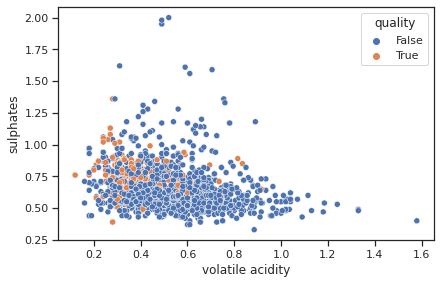

In [ ]:
sns.scatterplot(x = 'volatile acidity', y ='sulphates', data = df,  hue = df['quality'] == 7)

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [ ]:
# 3
y_train_full_3 = y_train_full == 3
polynomial_svm_clf = Pipeline([
            ("poly_features", PolynomialFeatures(degree=3)),
            ("scaler", StandardScaler()),
            ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=42))
        ])
polynomial_svm_clf.fit(X_train_full, y_train_full_3)
y_full_pred_3 = polynomial_svm_clf.predict(X_test_full)

# 4
y_train_full_4 = y_train_full == 4
polynomial_svm_clf = Pipeline([
            ("poly_features", PolynomialFeatures(degree=3)),
            ("scaler", StandardScaler()),
            ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
        ])
polynomial_svm_clf.fit(X_train_full, y_train_full_4)
y_full_pred_4 = polynomial_svm_clf.predict(X_test_full)

# 5
y_train_full_5 = y_train_full == 5
polynomial_svm_clf = Pipeline([
            ("poly_features", PolynomialFeatures(degree=3)),
            ("scaler", StandardScaler()),
            ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
        ])
polynomial_svm_clf.fit(X_train_full, y_train_full_5)
y_full_pred_5 = polynomial_svm_clf.predict(X_test_full)

# 6
y_train_full_6 = y_train_full == 6
polynomial_svm_clf = Pipeline([
            ("poly_features", PolynomialFeatures(degree=3)),
            ("scaler", StandardScaler()),
            ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
        ])
polynomial_svm_clf.fit(X_train_full, y_train_full_6)
y_full_pred_6 = polynomial_svm_clf.predict(X_test_full)

# 7
y_train_full_7 = y_train_full == 7
polynomial_svm_clf = Pipeline([
            ("poly_features", PolynomialFeatures(degree=3)),
            ("scaler", StandardScaler()),
            ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
        ])
polynomial_svm_clf.fit(X_train_full, y_train_full_7)
y_full_pred_7 = polynomial_svm_clf.predict(X_test_full)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
svc_result = pd.DataFrame({'Observed Quality': y_test_full})
svc_result['3'] = y_full_pred_3
svc_result['4'] = y_full_pred_4
svc_result['5'] = y_full_pred_5
svc_result['6'] = y_full_pred_6
svc_result['7'] = y_full_pred_7
svc_result['8'] = np.where(svc_result[['3','4','5','6','7']].any(axis=1), False, True)

pred = []
for i in range(svc_result.iloc[:,1:7].shape[0]):
  row = False
  j = 0
  while row == False and j < svc_result.iloc[:,1:7].shape[1]:
    row = svc_result.iloc[:,1:7].iloc[i,j]
    name = j+3
    j += 1
  if row == False:
    pred.insert(len(pred),'NA')
  else:
    pred.insert(len(pred),name)

pred2 = []
for i in range(svc_result.iloc[:,1:7].shape[0]):
  row = False
  j = svc_result.iloc[:,1:7].shape[1]-1
  while row == False and j >= 0:
    row = svc_result.iloc[:,1:7].iloc[i,j]
    name = j+3
    j -= 1
  if row == False:
    pred2.insert(len(pred),'NA')
  else:
    pred2.insert(len(pred),name)

svc_result['Predicted Quality Conservative'] = pred
svc_result['Predicted Quality Risky'] = pred2

In [ ]:
svc_result.head(10)

Observed Quality      3      4      5      6      7      8  \
803                  6  False  False   True  False  False  False   
124                  5  False  False   True  False  False  False   
350                  6  False  False  False   True  False  False   
682                  5  False  False   True  False  False  False   
1326                 6  False  False  False   True  False  False   
976                  5  False  False   True  False  False  False   
1493                 5  False  False   True  False  False  False   
706                  5  False  False   True  False  False  False   
613                  5  False  False  False   True  False  False   
1587                 6  False  False  False   True  False  False   

      Predicted Quality Conservative  Predicted Quality Risky  
803                                5                        5  
124                                5                        5  
350                                6                        6  
682                                5                        5  
1326                               6                        6  
976                                5                        5  
1493                               5                        5  
706                                5                        5  
613                                6                        6  
1587                               6                        6

In [ ]:
print(classification_report(svc_result['Observed Quality'], svc_result['Predicted Quality Conservative']))
print(classification_report(svc_result['Observed Quality'], svc_result['Predicted Quality Risky']))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        17
           5       0.69      0.74      0.71       195
           6       0.58      0.48      0.52       200
           7       0.48      0.21      0.30        61
           8       0.03      0.33      0.05         6

    accuracy                           0.53       480
   macro avg       0.30      0.29      0.26       480
weighted avg       0.58      0.53      0.55       480

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        17
           5       0.70      0.69      0.69       195
           6       0.59      0.51      0.55       200
           7       0.40      0.30      0.34        61
           8       0.03      0.33      0.05         6

    accuracy                           0.53       480
   macro avg       0.29

In [ ]:
print('MAE:', metrics.mean_absolute_error(svc_result['Observed Quality'], svc_result['Predicted Quality Conservative']))
print('MSE:', metrics.mean_squared_error(svc_result['Observed Quality'], svc_result['Predicted Quality Conservative']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(svc_result['Observed Quality'], svc_result['Predicted Quality Conservative'])))

MAE: 0.6645833333333333
MSE: 1.1895833333333334
RMSE: 1.09068021588976


In [ ]:
print('MAE:', metrics.mean_absolute_error(svc_result['Observed Quality'], svc_result['Predicted Quality Risky']))
print('MSE:', metrics.mean_squared_error(svc_result['Observed Quality'], svc_result['Predicted Quality Risky']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(svc_result['Observed Quality'], svc_result['Predicted Quality Risky'])))

MAE: 0.6583333333333333
MSE: 1.1625
RMSE: 1.0781929326423914


## 6. Random Forest with binary classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
binary_y_train = y_train_full.replace({3:0, 4:0, 5:0, 6:0, 7:1, 8:1})
binary_y_test = y_test_full.replace({3:0, 4:0, 5:0, 6:0, 7:1, 8:1})

In [ ]:
1 - 67/413

0.837772397094431

In [ ]:
clf = RandomForestClassifier(random_state = 42)
clf.fit(X_train_full, binary_y_train)
clf.score(X_test_full, binary_y_test)

0.89375

In [ ]:
param = {'criterion':['gini','entropy'],'n_estimators': range(100,400,100),'min_samples_split' : range(1,5,1),
         'min_samples_leaf' : range(1,5,1)}
clf = RandomForestClassifier(random_state = 42)
grid = GridSearchCV(clf,param_grid = param, cv = 3, verbose = 2, n_jobs = -1)
grid.fit(X_train_full, binary_y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5),
                         'n_estimators': range(100, 400, 100)},
             verbose=2)

In [ ]:
grid.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [ ]:
clf = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 1, min_samples_split = 4, n_estimators = 300, random_state = 42)
clf.fit(X_train_full, binary_y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=4,
                       n_estimators=300, random_state=42)

In [ ]:
clf.score(X_test_full, binary_y_test)

0.8979166666666667

In [ ]:
clf.score(X_train_full, binary_y_train)

0.9991063449508489

In [ ]:
print('MAE:', metrics.mean_absolute_error(clf.predict(X_test_full), binary_y_test))
print('MSE:', metrics.mean_squared_error(clf.predict(X_test_full), binary_y_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(clf.predict(X_test_full), binary_y_test)))

MAE: 0.10208333333333333
MSE: 0.10208333333333333
RMSE: 0.3195048252113469


In [ ]:
binary_y = y.replace({3:0, 4:0, 5:0, 6:0, 7:1, 8:1})
print(np.mean(cross_val_score(clf, X_full, binary_y, scoring='accuracy', cv=cv, n_jobs=-1)))

NameError: ignored

## 7. Random Forest

In [ ]:
param = {'criterion':['gini','entropy'],'n_estimators': range(100,400,100),'min_samples_split' : range(1,5,1),
         'min_samples_leaf' : range(1,5,1)}
clf = RandomForestClassifier(random_state = 42)
grid = GridSearchCV(clf,param_grid = param, cv = 3, verbose = 2, n_jobs = -1)
grid.fit(X_train_full, y_train_full)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5),
                         'n_estimators': range(100, 400, 100)},
             verbose=2)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [ ]:
clf = RandomForestClassifier(criterion = 'gini',n_estimators = 300, min_samples_split = 4, min_samples_leaf = 1, random_state = 42)
clf.fit(X_train_full, y_train_full)
clf.score(X_test_full, y_test_full)

0.6666666666666666

In [ ]:
pred_y = clf.predict(X_test_full)
comparison_df = pd.DataFrame({'pred_y':pred_y, 'actual_y': y_test_full})

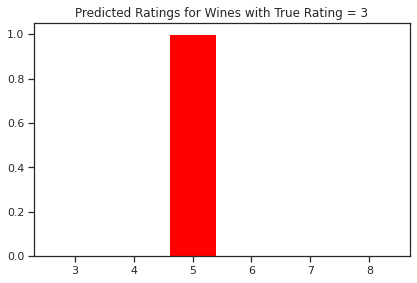

In [ ]:
d = {3:0,4:0,5:0,6:0,7:0,8:0}
for i in comparison_df[comparison_df['actual_y'] == 3]['pred_y'].value_counts().index:
  d[i] = comparison_df[comparison_df['actual_y'] == 3]['pred_y'].value_counts()[i]

plt.bar(x = [3,4,5,6,7,8], height = d.values(), 
        color = ['blue','red','red','red','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 3')
plt.show()

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 4')

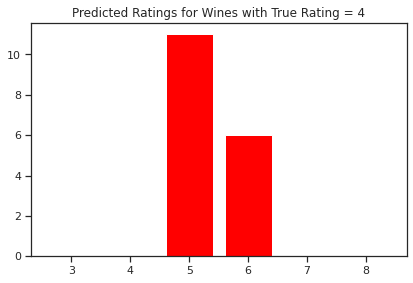

In [ ]:
d = {3:0,4:0,5:0,6:0,7:0,8:0}
for i in comparison_df[comparison_df['actual_y'] == 4]['pred_y'].value_counts().index:
  d[i] = comparison_df[comparison_df['actual_y'] == 4]['pred_y'].value_counts()[i]

plt.bar(x = [3,4,5,6,7,8], height = d.values(), 
        color = ['red','blue','red','red','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 4')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 5')

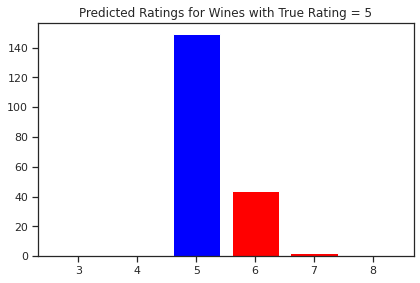

In [ ]:
d = {3:0,4:0,5:0,6:0,7:0,8:0}

for i in comparison_df[comparison_df['actual_y'] == 5]['pred_y'].value_counts().index:
  d[i] = comparison_df[comparison_df['actual_y'] == 5]['pred_y'].value_counts()[i]

plt.bar(x = [3,4,5,6,7,8], height = d.values(), 
        color = ['red','red','blue','red','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 5')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 6')

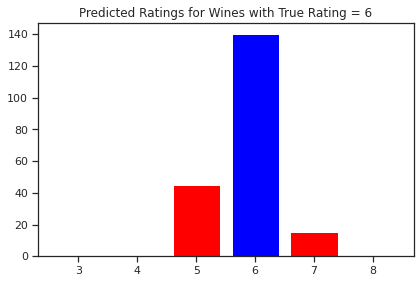

In [ ]:
d = {3:0,4:0,5:0,6:0,7:0,8:0}

for i in comparison_df[comparison_df['actual_y'] == 6]['pred_y'].value_counts().index:
  d[i] = comparison_df[comparison_df['actual_y'] == 6]['pred_y'].value_counts()[i]

plt.bar(x = [3,4,5,6,7,8], height = d.values(), 
        color = ['red','red','red','blue','red','red'])
plt.title('Predicted Ratings for Wines with True Rating = 6')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 7')

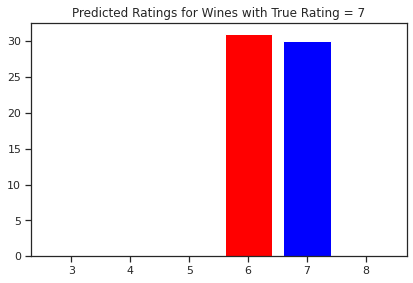

In [ ]:
d = {3:0,4:0,5:0,6:0,7:0,8:0}

for i in comparison_df[comparison_df['actual_y'] == 7]['pred_y'].value_counts().index:
  d[i] = comparison_df[comparison_df['actual_y'] == 7]['pred_y'].value_counts()[i]

plt.bar(x = [3,4,5,6,7,8], height = d.values(), 
        color = ['red','red','red','red','blue','red'])
plt.title('Predicted Ratings for Wines with True Rating = 7')

Text(0.5, 1.0, 'Predicted Ratings for Wines with True Rating = 8')

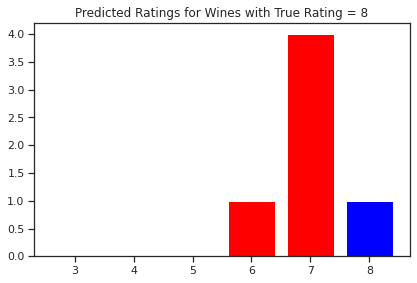

In [ ]:
d = {3:0,4:0,5:0,6:0,7:0,8:0}

for i in comparison_df[comparison_df['actual_y'] == 8]['pred_y'].value_counts().index:
  d[i] = comparison_df[comparison_df['actual_y'] == 8]['pred_y'].value_counts()[i]

plt.bar(x = [3,4,5,6,7,8], height = d.values(), 
        color = ['red','red','red','red','red','blue'])
plt.title('Predicted Ratings for Wines with True Rating = 8')

In [ ]:
import sklearn.metrics as metrics

In [ ]:
print('MAE:', metrics.mean_absolute_error(comparison_df['actual_y'], comparison_df['pred_y']))
print('MSE:', metrics.mean_squared_error(comparison_df['actual_y'], comparison_df['pred_y']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(comparison_df['actual_y'], comparison_df['pred_y'])))

MAE: 0.3541666666666667
MSE: 0.3958333333333333
RMSE: 0.6291528696058958


([<matplotlib.axis.XTick at 0x7f3956b2eb10>,
 <a list of 11 Text major ticklabel objects>)

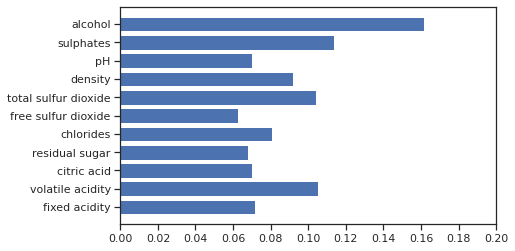

In [ ]:
# features importance
import matplotlib.pyplot as plt
%matplotlib inline

importance = clf.feature_importances_
feature_importance = dict(zip(X_train_full.columns,importance))

plt.barh(X_train_full.columns, importance)
plt.xticks(np.arange(0, 0.22, 0.02))
# print(X_full.columns)

In [ ]:
feature_importance

{'alcohol': 0.16181390066491821,
 'chlorides': 0.08055217451566314,
 'citric acid': 0.07012998138038033,
 'density': 0.09181073812977855,
 'fixed acidity': 0.07165051113283316,
 'free sulfur dioxide': 0.06270873567829877,
 'pH': 0.07028981955797926,
 'residual sugar': 0.06775832729011337,
 'sulphates': 0.11390968159295112,
 'total sulfur dioxide': 0.10420345456139914,
 'volatile acidity': 0.10517267549568507}

## 8. Ensemble Voting

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
clf_nn = MLPClassifier(hidden_layer_sizes = (12,10),activation = 'tanh', solver='adam',
                    random_state = 42, max_iter = 10000)
clf_tree = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5, 
                                  max_features=None,max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  random_state=42, splitter='best')
clf_rf = RandomForestClassifier(criterion = 'gini',n_estimators = 300, min_samples_split = 4, min_samples_leaf = 1, random_state = 42)

voting_clf = VotingClassifier(
    estimators=[('nn', clf_nn), ('rf', clf_rf), ('tree', clf_tree)],
    voting='soft', weights = [1,10,1])


In [ ]:
voting_clf.fit(X_train_full, y_train_full)
print(voting_clf.score(X_test_full, y_test_full))
print(np.mean(cross_val_score(voting_clf, X_full, y, scoring='accuracy', cv=cv, n_jobs=-1)))

0.6729166666666667
0.6779237023139463


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test_full, voting_clf.predict(X_test_full)))
print('MSE:', metrics.mean_squared_error(y_test_full, voting_clf.predict(X_test_full)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_full, voting_clf.predict(X_test_full))))

MAE: 0.35208333333333336
MSE: 0.40208333333333335
RMSE: 0.6341004126582267


## 9. Cross Validation Result of All Models

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
X = df.copy()
X = X.drop('quality', axis = 1)
y = df['quality']

cv = KFold(n_splits=3, random_state=42, shuffle=True)

In [ ]:
scores = cross_val_score(clf_rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.677 (0.023)


In [ ]:
scores = cross_val_score(clf_tree, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.570 (0.012)


In [ ]:
scores = cross_val_score(clf_nn, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.583 (0.020)


In [ ]:
scores = cross_val_score(voting_clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.678 (0.025)


In [ ]:
X1, X2, y1, y2 = train_test_split(X,y,test_size = 1/3, random_state=42)
X1, X3, y1, y3 = train_test_split(X1,y1,test_size = 1/2, random_state=42)
fold1 = [X1.append(X2), y1.append(y2), X3, y3]
fold2 = [X1.append(X3), y1.append(y3), X2, y2]
fold3 = [X3.append(X2), y3.append(y2), X1, y1]

In [ ]:
cv_accuracy_cons = []
cv_accuracy_risk = []
for fold in [fold1, fold2, fold3]:
  X_train = fold[0]
  y_train = fold[1]
  X_test = fold[2]
  y_test = fold[3]
  # 3
  y_train_3 = y_train == 3
  polynomial_svm_clf = Pipeline([
              ("poly_features", PolynomialFeatures(degree=3)),
              ("scaler", StandardScaler()),
              ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=42))
          ])
  polynomial_svm_clf.fit(X_train, y_train_3)
  y_pred_3 = polynomial_svm_clf.predict(X_test)

  # 4
  y_train_4 = y_train == 4
  polynomial_svm_clf = Pipeline([
              ("poly_features", PolynomialFeatures(degree=3)),
              ("scaler", StandardScaler()),
              ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
          ])
  polynomial_svm_clf.fit(X_train, y_train_4)
  y_pred_4 = polynomial_svm_clf.predict(X_test)

  # 5
  y_train_5 = y_train == 5
  polynomial_svm_clf = Pipeline([
              ("poly_features", PolynomialFeatures(degree=3)),
              ("scaler", StandardScaler()),
              ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
          ])
  polynomial_svm_clf.fit(X_train, y_train_5)
  y_pred_5 = polynomial_svm_clf.predict(X_test)

  # 6
  y_train_6 = y_train == 6
  polynomial_svm_clf = Pipeline([
              ("poly_features", PolynomialFeatures(degree=3)),
              ("scaler", StandardScaler()),
              ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
          ])
  polynomial_svm_clf.fit(X_train, y_train_6)
  y_pred_6 = polynomial_svm_clf.predict(X_test)

  # 7
  y_train_7 = y_train == 7
  polynomial_svm_clf = Pipeline([
              ("poly_features", PolynomialFeatures(degree=3)),
              ("scaler", StandardScaler()),
              ("svm_clf", LinearSVC(C=10, loss="hinge",max_iter=10000, random_state=4))
          ])
  polynomial_svm_clf.fit(X_train, y_train_7)
  y_pred_7 = polynomial_svm_clf.predict(X_test)

  svc_result = pd.DataFrame({'Observed Quality': y_test})
  svc_result['3'] = y_pred_3
  svc_result['4'] = y_pred_4
  svc_result['5'] = y_pred_5
  svc_result['6'] = y_pred_6
  svc_result['7'] = y_pred_7
  svc_result['8'] = np.where(svc_result[['3','4','5','6','7']].any(axis=1), False, True)

  pred1 = []
  for i in range(svc_result.iloc[:,1:7].shape[0]):
    row = False
    j = 0
    while row == False and j < svc_result.iloc[:,1:7].shape[1]:
      row = svc_result.iloc[:,1:7].iloc[i,j]
      name = j+3
      j += 1
    if row == False:
      pred1.insert(len(pred1),'NA')
    else:
      pred1.insert(len(pred1),name)

  pred2 = []
  for i in range(svc_result.iloc[:,1:7].shape[0]):
    row = False
    j = svc_result.iloc[:,1:7].shape[1]-1
    while row == False and j >= 0:
      row = svc_result.iloc[:,1:7].iloc[i,j]
      name = j+3
      j -= 1
    if row == False:
      pred2.insert(len(pred),'NA')
    else:
      pred2.insert(len(pred),name)

  cv_accuracy_cons.append(accuracy_score(y_test, pred1))
  cv_accuracy_risk.append(accuracy_score(y_test, pred2))

print(np.mean(cv_accuracy_cons))
print(np.mean(cv_accuracy_risk))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

0.5434646654158849
0.5134459036898061
